In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import math
import time
from data import inputs
import numpy as np
import tensorflow as tf
from model import select_model, get_checkpoint
from utils import *
import os
import json
import csv
from glob import glob

/home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/s

In [2]:
# python guess.py --model_type inception --model_dir ./age/ --filename ../../recommendation/images/lahiru_23_malexxx_1.png 


In [3]:

RESIZE_FINAL = 227
# GENDER_LIST =['M','F']
AGE_LIST = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)','(25, 32)','(38, 43)','(48, 53)','(60, 100)']
MAX_BATCH_SZ = 128

tf.app.flags.DEFINE_string('model_dir', './age',
                           'Model directory (where training data lives)')

tf.app.flags.DEFINE_string('class_type', 'age',
                           'Classification type (age|gender)')


tf.app.flags.DEFINE_string('device_id', '/cpu:0',
                           'What processing unit to execute inference on')

tf.app.flags.DEFINE_string('filename', '../recommendation/images/lahiru_23_malexxx_1.png',
                           'File (Image) or File list (Text/No header TSV) to process')

tf.app.flags.DEFINE_string('target', '',
                           'CSV file containing the filename processed along with best guess and score')

tf.app.flags.DEFINE_string('checkpoint', 'checkpoint',
                          'Checkpoint basename')

tf.app.flags.DEFINE_string('model_type', 'inception',
                           'Type of convnet')

tf.app.flags.DEFINE_string('requested_step', '', 'Within the model directory, a requested step to restore e.g., 9000')

tf.app.flags.DEFINE_boolean('single_look', False, 'single look at the image or multiple crops')

tf.app.flags.DEFINE_string('face_detection_model', '', 'Do frontal face detection with model specified')

tf.app.flags.DEFINE_string('face_detection_type', 'cascade', 'Face detection model type (yolo_tiny|cascade)')

FLAGS = tf.app.flags.FLAGS

In [4]:

def one_of(fname, types):
    return any([fname.endswith('.' + ty) for ty in types])

def resolve_file(fname):
    if os.path.exists(fname): return fname
    for suffix in ('.jpg', '.png', '.JPG', '.PNG', '.jpeg'):
        cand = fname + suffix
        if os.path.exists(cand):
            return cand
    return None


def classify_many_single_crop(sess, label_list, softmax_output, coder, images, image_files, writer):
    try:
        num_batches = math.ceil(len(image_files) / MAX_BATCH_SZ)
        pg = ProgressBar(num_batches)
        for j in range(num_batches):
            start_offset = j * MAX_BATCH_SZ
            end_offset = min((j + 1) * MAX_BATCH_SZ, len(image_files))
            
            batch_image_files = image_files[start_offset:end_offset]
            print(start_offset, end_offset, len(batch_image_files))
            image_batch = make_multi_image_batch(batch_image_files, coder)
            batch_results = sess.run(softmax_output, feed_dict={images:image_batch.eval()})
            batch_sz = batch_results.shape[0]
            for i in range(batch_sz):
                output_i = batch_results[i]
                best_i = np.argmax(output_i)
                best_choice = (label_list[best_i], output_i[best_i])
                print('Guess @ 1 %s, prob = %.2f' % best_choice)
                if writer is not None:
                    f = batch_image_files[i]
                    writer.writerow((f, best_choice[0], '%.2f' % best_choice[1]))
            pg.update()
        pg.done()
    except Exception as e:
        print(e)
        print('Failed to run all images')

def classify_one_multi_crop(sess, label_list, softmax_output, coder, images, image_file, writer):
    try:

        print('Running file %s' % image_file)
        image_batch = make_multi_crop_batch(image_file, coder)

        batch_results = sess.run(softmax_output, feed_dict={images:image_batch.eval()})
        output = batch_results[0]
        batch_sz = batch_results.shape[0]
    
        for i in range(1, batch_sz):
            output = output + batch_results[i]
        
        output /= batch_sz
        best = np.argmax(output)
        best_choice = (label_list[best], output[best])
        print('Guess @ 1 %s, prob = %.2f' % best_choice)
    
        nlabels = len(label_list)
        if nlabels > 2:
            output[best] = 0
            second_best = np.argmax(output)
            print('Guess @ 2 %s, prob = %.2f' % (label_list[second_best], output[second_best]))

        if writer is not None:
            writer.writerow((image_file, best_choice[0], '%.2f' % best_choice[1]))
    except Exception as e:
        print(e)
        print('Failed to run image %s ' % image_file)

def list_images(srcfile):
    with open(srcfile, 'r') as csvfile:
        delim = ',' if srcfile.endswith('.csv') else '\t'
        reader = csv.reader(csvfile, delimiter=delim)
        if srcfile.endswith('.csv') or srcfile.endswith('.tsv'):
            print('skipping header')
            _ = next(reader)
        
        return [row[0] for row in reader]


In [5]:
def main(argv=None):  # pylint: disable=unused-argument

#     files = []
    files = glob('../recommendation/images/*')
    
    if FLAGS.face_detection_model:
        print('Using face detector (%s) %s' % (FLAGS.face_detection_type, FLAGS.face_detection_model))
        face_detect = face_detection_model(FLAGS.face_detection_type, FLAGS.face_detection_model)
        face_files, rectangles = face_detect.run(FLAGS.filename)
        print(face_files)
        files += face_files

    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(config=config) as sess:

        label_list = AGE_LIST if FLAGS.class_type == 'age' else GENDER_LIST
        nlabels = len(label_list)

        print('Executing on %s' % FLAGS.device_id)
        model_fn = select_model(FLAGS.model_type)

        with tf.device(FLAGS.device_id):
            
            images = tf.placeholder(tf.float32, [None, RESIZE_FINAL, RESIZE_FINAL, 3])
            logits = model_fn(nlabels, images, 1, False)
            init = tf.global_variables_initializer()
            
            requested_step = FLAGS.requested_step if FLAGS.requested_step else None
        
            checkpoint_path = '%s' % (FLAGS.model_dir)

            model_checkpoint_path, global_step = get_checkpoint(checkpoint_path, requested_step, FLAGS.checkpoint)
            
            saver = tf.train.Saver()
            saver.restore(sess, model_checkpoint_path)
                        
            softmax_output = tf.nn.softmax(logits)

            coder = ImageCoder()

            # Support a batch mode if no face detection model
            if len(files) == 0:
                if (os.path.isdir(FLAGS.filename)):
                    for relpath in os.listdir(FLAGS.filename):
                        abspath = os.path.join(FLAGS.filename, relpath)
                        
                        if os.path.isfile(abspath) and any([abspath.endswith('.' + ty) for ty in ('jpg', 'png', 'JPG', 'PNG', 'jpeg')]):
                            print(abspath)
                            files.append(abspath)
                else:
                    files.append(FLAGS.filename)
                    # If it happens to be a list file, read the list and clobber the files
                    if any([FLAGS.filename.endswith('.' + ty) for ty in ('csv', 'tsv', 'txt')]):
                        files = list_images(FLAGS.filename)
                
            writer = None
            output = None
            if FLAGS.target:
                print('Creating output file %s' % FLAGS.target)
                output = open(FLAGS.target, 'w')
                writer = csv.writer(output)
                writer.writerow(('file', 'label', 'score'))
            image_files = list(filter(lambda x: x is not None, [resolve_file(f) for f in files]))
            print(image_files)
            if FLAGS.single_look:
                classify_many_single_crop(sess, label_list, softmax_output, coder, images, image_files, writer)

            else:
                for image_file in image_files:
                    classify_one_multi_crop(sess, label_list, softmax_output, coder, images, image_file, writer)

            if output is not None:
                output.close()
        

In [6]:
tf.app.run()

Executing on /cpu:0
selected (fine-tuning) inception model



W0703 16:37:41.660514 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/model.py:77: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0703 16:37:41.723783 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f6f15d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f6f15d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.745929 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1e8c10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1e8c10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.802588 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f6f1310>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f6f1310>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.824610 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1b3e50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1b3e50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.883136 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.905247 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1120d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1120d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:41.944004 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff62f69c210>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff62f69c210>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.001230 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1ea890>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1ea890>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.024873 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c266790>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c266790>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.083652 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a59d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a59d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.106125 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c0d3a10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c0d3a10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.145008 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff62c1a6a10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff62c1a6a10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.201849 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c0d3ad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c0d3ad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.224206 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c112350>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c112350>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.356506 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a5810>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a5810>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.378781 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1a6b10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1a6b10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.436900 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.459038 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61450be90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61450be90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.517576 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1eaa10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.539730 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441e7d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441e7d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.603468 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff64aa72190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff64aa72190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.625509 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441e590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441e590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.685373 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61450dcd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61450dcd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.707447 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614417510>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614417510>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.750890 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff62c06be50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff62c06be50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.808017 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c10b710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c10b710>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.830319 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614346790>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614346790>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.889002 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f60d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f60d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.911679 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614417850>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff614417850>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.972706 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:42.994837 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6142889d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6142889d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.058095 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c0d3ed0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c0d3ed0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.080122 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441ead0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61441ead0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.137790 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c06ee10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c06ee10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.159746 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6141e2090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6141e2090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.217870 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143fb6d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143fb6d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.240272 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6140ffa10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6140ffa10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.302637 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff63724f950>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff63724f950>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.324811 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6140ef190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff6140ef190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.364411 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff614347a90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff614347a90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.421111 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614274790>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614274790>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.443502 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61406a590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61406a590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.501932 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614346c50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614346c50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.524577 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc77f310>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc77f310>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.582661 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6140fb610>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6140fb610>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.604851 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc75aad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc75aad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.665458 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f6410>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f6410>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.687704 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6c8090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6c8090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.746487 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f6ad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6143f6ad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.768705 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6a6350>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6a6350>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.826858 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.848984 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6c3850>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc6c3850>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.909208 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61450b9d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61450b9d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.931447 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc5e8b10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc5e8b10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:43.970688 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff6140802d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff6140802d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.031208 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61404b510>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61404b510>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.053832 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc5e1350>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc5e1350>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.115620 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1f9bd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1f9bd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.137873 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc53efd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc53efd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.196251 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.218758 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc75aed0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc75aed0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.278041 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614206a10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614206a10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.300238 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc544c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc544c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.358420 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc5b2f50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc5b2f50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.380635 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc461790>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc461790>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.419880 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff5fc7f20d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff5fc7f20d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.559468 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc573d50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc573d50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.582534 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61450d250>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff61450d250>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.640782 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc75a550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc75a550>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.663068 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc472410>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc472410>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.721651 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1d6c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1d6c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.743946 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c0b1390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c0b1390>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.802534 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6140ef090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6140ef090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.824747 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc472150>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc472150>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.884316 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1d6c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1d6c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.906567 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc215c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc215c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.971428 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc3ca690>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc3ca690>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:44.994437 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc195390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc195390>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.054360 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc66f6d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc66f6d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.077282 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0faf50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0faf50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.136529 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc234710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc234710>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.158630 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0d2810>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0d2810>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.217439 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc3ca690>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc3ca690>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.239592 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0c6290>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0c6290>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.278348 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5fc230c50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5fc230c50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.334207 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1f92d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1f92d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.356977 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d87d12d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d87d12d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.416160 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc215950>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc215950>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.443055 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0d8110>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc0d8110>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.501385 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614120810>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614120810>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.523545 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c05df10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c05df10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.582172 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c05d5d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c05d5d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.604318 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d870d690>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d870d690>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.662490 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.684698 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8682850>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8682850>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.746081 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc46fb50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc46fb50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.768237 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8665d90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8665d90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.826266 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc0aae10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc0aae10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.848571 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d85a3f90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d85a3f90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.910495 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc472c50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc472c50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.933317 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d862d7d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d862d7d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:45.992078 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a6510>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a6510>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.014568 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1973d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff62c1973d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.074419 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d85bded0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d85bded0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.096673 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8574590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8574590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.141505 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d85a97d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d85a97d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.199649 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6032d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.222325 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8444b90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8444b90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.280819 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d84feb90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d84feb90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.304001 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d84b5b50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d84b5b50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.362557 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc0aa090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc0aa090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.385095 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d84461d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d84461d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.445864 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.468559 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8446ad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8446ad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.528132 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8574050>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8574050>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.550440 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d82c2210>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d82c2210>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.609367 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6142e7650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6142e7650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.632067 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d837ba10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d837ba10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.690961 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc2df6d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc2df6d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.713299 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d838c390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d838c390>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.773116 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.801066 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d82a8810>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d82a8810>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.859443 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8665850>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8665850>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.882217 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8121d90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8121d90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.940490 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d837ba10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d837ba10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:46.963033 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d814f3d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d814f3d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.002235 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d820db50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d820db50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.059168 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8574050>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8574050>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.081802 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b47d8650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b47d8650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.239688 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8205090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8205090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.262831 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc30ed90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc30ed90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.321975 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d81e0e50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d81e0e50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.345099 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8082e90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8082e90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.404513 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8412d50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d8412d50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.426961 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8205090>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8205090>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.486590 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc573d50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc573d50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.514061 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b46cce50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b46cce50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.572487 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc692fd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc692fd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.594569 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8082e50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5d8082e50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.652890 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d81f9bd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d81f9bd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.676161 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc46f610>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5fc46f610>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.736454 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a6610>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1a6610>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.758376 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4544950>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4544950>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.817351 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.839525 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b45384d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b45384d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.898545 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b46cc950>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b46cc950>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.920415 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4538450>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4538450>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:47.959175 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5b476ea10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5b476ea10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.020500 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4776e50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4776e50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.042966 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4522b50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4522b50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.102337 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b45e2290>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b45e2290>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.124818 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b448b250>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b448b250>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.184868 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4522350>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4522350>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.207015 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b46b5110>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b46b5110>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.266024 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b45223d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b45223d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.288186 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b45380d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b45380d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.348220 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f69c210>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62f69c210>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.370478 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4477ad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4477ad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.429371 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4465f10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4465f10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.451543 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43de510>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43de510>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.509424 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b46c0ed0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b46c0ed0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.531568 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43acdd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43acdd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.570351 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff5b44777d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.MaxPooling2D object at 0x7ff5b44777d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.627685 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6144efe10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff6144efe10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.650126 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b426a6d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b426a6d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.707266 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.730164 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4106ad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4106ad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.787907 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4267190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4267190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.810071 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b40e7110>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b40e7110>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.873008 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff614442650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.895471 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4178fd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b4178fd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.956459 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1b3250>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1b3250>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:48.978729 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987f0dd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987f0dd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.037958 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1b3f90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff62c1b3f90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.060164 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43acd90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5b43acd90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.118344 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61441bad0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff61441bad0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.140615 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598747350>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598747350>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.198543 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4471e90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4471e90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.220685 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987b4610>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987b4610>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.260183 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5b41c6190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5b41c6190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.317458 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b41a0b50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b41a0b50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.340638 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59868bf10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59868bf10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.399599 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4055d90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b4055d90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.422279 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987f06d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5987f06d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.482679 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d873e590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.505370 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59859cb10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59859cb10>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.563485 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6c8650>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5fc6c8650>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.586251 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598724690>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598724690>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.648571 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b41c6190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5b41c6190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.671204 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5985104d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5985104d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.730222 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d84c4b50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5d84c4b50>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.753049 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5985d9750>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff5985d9750>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.811713 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff59868bdd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff59868bdd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.834026 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59847d210>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff59847d210>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.898397 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5985d26d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff5985d26d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.921444 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598521c90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598521c90>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:49.981273 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff59868bdd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff59868bdd0>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:50.004398 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598432810>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598432810>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:50.045552 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d873e590>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff5d873e590>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:50.102426 140698822833920 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff598542310>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7ff598542310>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:50.126767 140698822833920 ag_logging.py:145] Entity <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598297190>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method BatchNormalization.call of <tensorflow.python.layers.normalization.BatchNormalization object at 0x7ff598297190>>: AssertionError: Bad argument number for Name: 3, expecting 4


W0703 16:37:50.167109 140698822833920 ag_logging.py:145] Entity <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff62f6f15d0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Pooling2D.call of <tensorflow.python.layers.pooling.AveragePooling2D object at 0x7ff62f6f15d0>>: AssertionError: Bad argument number for Name: 3, expecting 4


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0703 16:37:50.169880 140698822833920 deprecation.py:506] From /home/hicup/Documents/ad-recommendation/demography/model.py:93: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use keras.layers.flatten instead.


W0703 16:37:50.170933 140698822833920 deprecation.py:323] From /home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


W0703 16:37:50.181968 140698822833920 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x7ff5b44c0bd0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x7ff5b44c0bd0>>: AttributeError: module 'gast' has no attribute 'Num'


W0703 16:37:50.294638 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/model.py:98: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.



W0703 16:37:50.302795 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/model.py:54: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



W0703 16:37:50.304963 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/model.py:55: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.



./age/checkpoint-14999
Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0703 16:37:50.517291 140698822833920 deprecation.py:323] From /home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./age/checkpoint-14999


I0703 16:37:50.519165 140698822833920 saver.py:1280] Restoring parameters from ./age/checkpoint-14999


W0703 16:37:50.878445 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/utils.py:62: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



W0703 16:37:50.879692 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/utils.py:63: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



W0703 16:37:50.890815 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/utils.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



W0703 16:37:50.894264 140698822833920 deprecation_wrapper.py:119] From /home/hicup/Documents/ad-recommendation/demography/utils.py:73: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.



['../recommendation/images/chathuranga_22_male_1.png', '../recommendation/images/ishen_15_m_2.png', '../recommendation/images/Anjanee_23_female_2.png', '../recommendation/images/chathuranga_22_male_2.png', '../recommendation/images/sadew_15_m_2.png', '../recommendation/images/Sandul_23_male_1.png', '../recommendation/images/raveesha_male_16_2.png', '../recommendation/images/Lal_64_M_2.png', '../recommendation/images/sadula_22_male_2.png', '../recommendation/images/jeewantha01_2.png', '../recommendation/images/shenal_21_Male_1.png', '../recommendation/images/Sajith_28_male_2.png', '../recommendation/images/Ranumi_9_female_1.png', '../recommendation/images/Lahiru_23_male_1.png', '../recommendation/images/pramodya_15_m_2.png', '../recommendation/images/mithun_6_m_1.png', '../recommendation/images/test123_2.png', '../recommendation/images/Rajitha_22_Male_2.png', '../recommendation/images/dilini_39_Female_1.png', '../recommendation/images/Vimukthi_23_M_1.png', '../recommendation/images/test

W0703 16:37:50.898829 140698822833920 deprecation.py:323] From /home/hicup/Documents/ad-recommendation/demography/utils.py:133: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


Converting PNG to JPEG for ../recommendation/images/chathuranga_22_male_1.png
Running multi-cropped image
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0703 16:37:51.025134 140698822833920 deprecation.py:323] From /home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1514: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Guess @ 1 (25, 32), prob = 0.48
Guess @ 2 (38, 43), prob = 0.29
Running file ../recommendation/images/ishen_15_m_2.png
Converting PNG to JPEG for ../recommendation/images/ishen_15_m_2.png
Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.47
Guess @ 2 (25, 32), prob = 0.25
Running file ../recommendation/images/Anjanee_23_female_2.png
Converting PNG to JPEG for ../recommendation/images/Anjanee_23_female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.85
Guess @ 2 (38, 43), prob = 0.07
Running file ../recommendation/images/chathuranga_22_male_2.png
Converting PNG to JPEG for ../recommendation/images/chathuranga_22_male_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.65
Guess @ 2 (38, 43), prob = 0.13
Running file ../recommendation/images/sadew_15_m_2.png
Converting PNG to JPEG for ../recommendation/images/sadew_15_m_2.png
Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.37
Guess @ 2 (25, 32), prob = 0.34
Running file ../recommendation/images/Sa

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.43
Guess @ 2 (15, 20), prob = 0.29
Running file ../recommendation/images/Ramesha_15_f_1.png
Converting PNG to JPEG for ../recommendation/images/Ramesha_15_f_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.93
Guess @ 2 (48, 53), prob = 0.03
Running file ../recommendation/images/Venura_23_male_1.png
Converting PNG to JPEG for ../recommendation/images/Venura_23_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.56
Guess @ 2 (15, 20), prob = 0.25
Running file ../recommendation/images/Rajitha_22_Male_1.png
Converting PNG to JPEG for ../recommendation/images/Rajitha_22_Male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.78
Guess @ 2 (48, 53), prob = 0.12
Running file ../recommendation/images/medhavi_25_female_2.png
Converting PNG to JPEG for ../recommendation/images/medhavi_25_female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.92
Guess @ 2 (38, 43), prob = 0.04
Running 

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.64
Guess @ 2 (15, 20), prob = 0.20
Running file ../recommendation/images/Shehani_30_female_1.png
Converting PNG to JPEG for ../recommendation/images/Shehani_30_female_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.47
Guess @ 2 (38, 43), prob = 0.27
Running file ../recommendation/images/Hiruni_23_Female_2.png
Converting PNG to JPEG for ../recommendation/images/Hiruni_23_Female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.99
Guess @ 2 (15, 20), prob = 0.01
Running file ../recommendation/images/Nilanthi_50_Female_2.png
Converting PNG to JPEG for ../recommendation/images/Nilanthi_50_Female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.64
Guess @ 2 (38, 43), prob = 0.27
Running file ../recommendation/images/mallika_51_female_2.png
Converting PNG to JPEG for ../recommendation/images/mallika_51_female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.74
Guess @ 2 (48, 53), 

Guess @ 1 (25, 32), prob = 0.93
Guess @ 2 (48, 53), prob = 0.04
Running file ../recommendation/images/Kinsly_75_M_2.png
Converting PNG to JPEG for ../recommendation/images/Kinsly_75_M_2.png
Running multi-cropped image
Guess @ 1 (48, 53), prob = 0.42
Guess @ 2 (15, 20), prob = 0.30
Running file ../recommendation/images/Nayanathara_25_ female _2.png
Converting PNG to JPEG for ../recommendation/images/Nayanathara_25_ female _2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.81
Guess @ 2 (38, 43), prob = 0.17
Running file ../recommendation/images/ashinsana_20_male_1.png
Converting PNG to JPEG for ../recommendation/images/ashinsana_20_male_1.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.49
Guess @ 2 (25, 32), prob = 0.47
Running file ../recommendation/images/Ex-Id-Palindi-22-Female_1.png
Converting PNG to JPEG for ../recommendation/images/Ex-Id-Palindi-22-Female_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.72
Guess @ 2 (15, 20), prob = 0.27
Runn

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.93
Guess @ 2 (48, 53), prob = 0.05
Running file ../recommendation/images/pramodya_16_m_2.png
Converting PNG to JPEG for ../recommendation/images/pramodya_16_m_2.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.39
Guess @ 2 (25, 32), prob = 0.21
Running file ../recommendation/images/Desilva_23_M_1.png
Converting PNG to JPEG for ../recommendation/images/Desilva_23_M_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.93
Guess @ 2 (15, 20), prob = 0.05
Running file ../recommendation/images/Sudesha_24_male_1.png
Converting PNG to JPEG for ../recommendation/images/Sudesha_24_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.37
Guess @ 2 (8, 12), prob = 0.20
Running file ../recommendation/images/sadew_15_m_1.png
Converting PNG to JPEG for ../recommendation/images/sadew_15_m_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.65
Guess @ 2 (38, 43), prob = 0.14
Running file ../recommend

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.99
Guess @ 2 (15, 20), prob = 0.00
Running file ../recommendation/images/enoka_53_female_1.png
Converting PNG to JPEG for ../recommendation/images/enoka_53_female_1.png
Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.67
Guess @ 2 (25, 32), prob = 0.25
Running file ../recommendation/images/Haritha_22_male_2.png
Converting PNG to JPEG for ../recommendation/images/Haritha_22_male_2.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.69
Guess @ 2 (25, 32), prob = 0.31
Running file ../recommendation/images/Deshani_24_F_2.png
Converting PNG to JPEG for ../recommendation/images/Deshani_24_F_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.84
Guess @ 2 (15, 20), prob = 0.15
Running file ../recommendation/images/Dilmi_22_female_1.png
Converting PNG to JPEG for ../recommendation/images/Dilmi_22_female_1.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.44
Guess @ 2 (25, 32), prob = 0.30
Running fi

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.76
Guess @ 2 (15, 20), prob = 0.14
Running file ../recommendation/images/Rochelle_36_Female_2.png
Converting PNG to JPEG for ../recommendation/images/Rochelle_36_Female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.93
Guess @ 2 (15, 20), prob = 0.07
Running file ../recommendation/images/sadun_20_male_1.png
Converting PNG to JPEG for ../recommendation/images/sadun_20_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.71
Guess @ 2 (15, 20), prob = 0.14
Running file ../recommendation/images/Mishara_23_M_1.png
Converting PNG to JPEG for ../recommendation/images/Mishara_23_M_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.43
Guess @ 2 (38, 43), prob = 0.37
Running file ../recommendation/images/Lakshan 27 m_2.png
Converting PNG to JPEG for ../recommendation/images/Lakshan 27 m_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.87
Guess @ 2 (8, 12), prob = 0.10
Running file ..

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.46
Guess @ 2 (15, 20), prob = 0.25
Running file ../recommendation/images/jeewantha01_25_male_1.png
Converting PNG to JPEG for ../recommendation/images/jeewantha01_25_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.91
Guess @ 2 (15, 20), prob = 0.07
Running file ../recommendation/images/dilini_39_Female_2.png
Converting PNG to JPEG for ../recommendation/images/dilini_39_Female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.84
Guess @ 2 (15, 20), prob = 0.07
Running file ../recommendation/images/sachindu_23_male_1.png
Converting PNG to JPEG for ../recommendation/images/sachindu_23_male_1.png
Running multi-cropped image
Guess @ 1 (8, 12), prob = 0.53
Guess @ 2 (15, 20), prob = 0.25
Running file ../recommendation/images/hasitha_23_male_1.png
Converting PNG to JPEG for ../recommendation/images/hasitha_23_male_1.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.65
Guess @ 2 (25, 32), prob 

Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.53
Guess @ 2 (15, 20), prob = 0.23
Running file ../recommendation/images/manuja_22_male_2.png
Converting PNG to JPEG for ../recommendation/images/manuja_22_male_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.96
Guess @ 2 (15, 20), prob = 0.02
Running file ../recommendation/images/Oshadi_21_Female_1.png
Converting PNG to JPEG for ../recommendation/images/Oshadi_21_Female_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.43
Guess @ 2 (8, 12), prob = 0.30
Running file ../recommendation/images/malani_67_female_1.png
Converting PNG to JPEG for ../recommendation/images/malani_67_female_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.60
Guess @ 2 (48, 53), prob = 0.18
Running file ../recommendation/images/gavindu_21_male_2.png
Converting PNG to JPEG for ../recommendation/images/gavindu_21_male_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.99
Guess @ 2 (15, 20), prob = 0.00
Run

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.70
Guess @ 2 (38, 43), prob = 0.28
Running file ../recommendation/images/nimsara_21_male_2.png
Converting PNG to JPEG for ../recommendation/images/nimsara_21_male_2.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.36
Guess @ 2 (25, 32), prob = 0.32
Running file ../recommendation/images/Dinuka_17_male_2.png
Converting PNG to JPEG for ../recommendation/images/Dinuka_17_male_2.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.74
Guess @ 2 (25, 32), prob = 0.13
Running file ../recommendation/images/Sandul_23_male_2.png
Converting PNG to JPEG for ../recommendation/images/Sandul_23_male_2.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.95
Guess @ 2 (25, 32), prob = 0.05
Running file ../recommendation/images/Akasha_12_Female_2.png
Converting PNG to JPEG for ../recommendation/images/Akasha_12_Female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.54
Guess @ 2 (38, 43), prob = 0.30
Runnin

Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.53
Guess @ 2 (25, 32), prob = 0.25
Running file ../recommendation/images/Thisal_22_male_2.png
Converting PNG to JPEG for ../recommendation/images/Thisal_22_male_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.98
Guess @ 2 (15, 20), prob = 0.02
Running file ../recommendation/images/Ranula_24_M_1.png
Converting PNG to JPEG for ../recommendation/images/Ranula_24_M_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 1.00
Guess @ 2 (15, 20), prob = 0.00
Running file ../recommendation/images/dewdun_15_m_1.png
Converting PNG to JPEG for ../recommendation/images/dewdun_15_m_1.png
Running multi-cropped image
Guess @ 1 (15, 20), prob = 0.57
Guess @ 2 (25, 32), prob = 0.39
Running file ../recommendation/images/pubudu_23_male_2.png
Converting PNG to JPEG for ../recommendation/images/pubudu_23_male_2.png
Running multi-cropped image
Guess @ 1 (38, 43), prob = 0.55
Guess @ 2 (25, 32), prob = 0.26
Running file ../recommen

Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.75
Guess @ 2 (38, 43), prob = 0.11
Running file ../recommendation/images/vishvakumara_21_male_2.png
Converting PNG to JPEG for ../recommendation/images/vishvakumara_21_male_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.66
Guess @ 2 (48, 53), prob = 0.15
Running file ../recommendation/images/manuja_22_male_1.png
Converting PNG to JPEG for ../recommendation/images/manuja_22_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.84
Guess @ 2 (15, 20), prob = 0.13
Running file ../recommendation/images/ravindu_23_male_1.png
Converting PNG to JPEG for ../recommendation/images/ravindu_23_male_1.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 0.87
Guess @ 2 (38, 43), prob = 0.11
Running file ../recommendation/images/chandula_24_female_2.png
Converting PNG to JPEG for ../recommendation/images/chandula_24_female_2.png
Running multi-cropped image
Guess @ 1 (25, 32), prob = 1.00
Guess @ 2 (15, 20), pr

SystemExit: 

/home/hicup/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


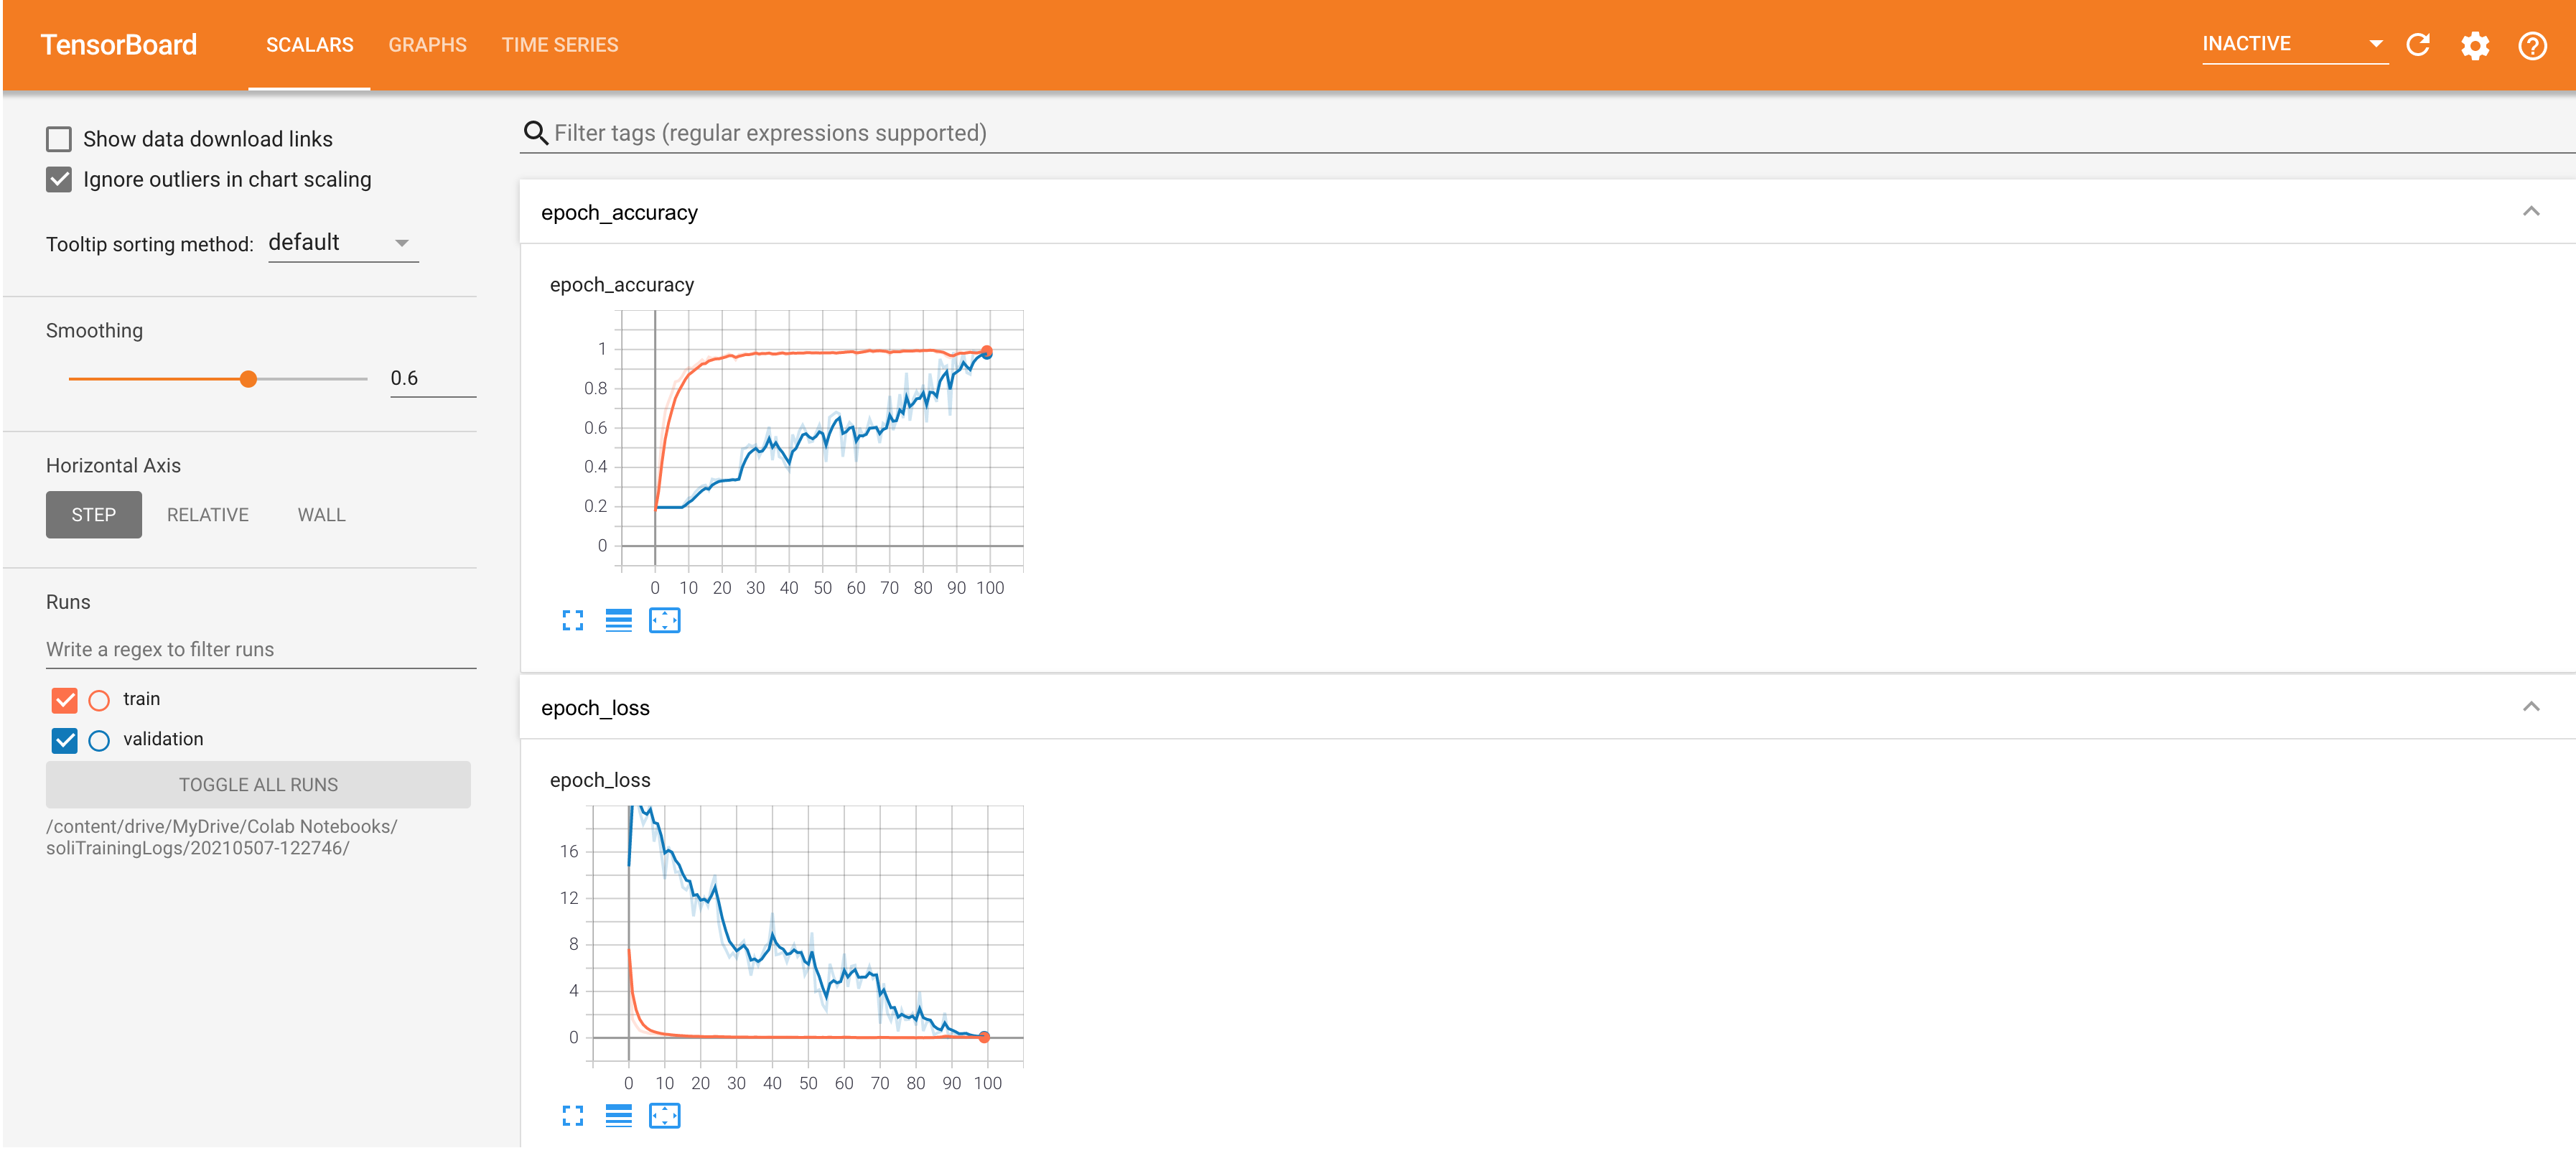